In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Dense, Activation, add, Flatten, GlobalAveragePooling2D, concatenate, Reshape, multiply
from keras.models import Model

from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Dense, Activation, add, Flatten, AveragePooling2D, concatenate
from keras.models import Model

from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
from keras.utils import np_utils

width = 32
height = 32

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


https://keras.io/api/layers/

In [ ]:
num_classes = 10
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [ ]:
validation_images, validation_labels = x_train[:500], y_train[:500]
train_images, train_labels = x_train[500:], y_train[500:]

In [ ]:
train_images.shape

(49500, 32, 32, 3)

In [ ]:
def SEmodule(pre_layer, ch, r): 
  #pre_layer : 입력(w,h,c), ch : channel, r :16
  
    x = GlobalAveragePooling2D()(pre_layer)

    x = Dense(int(ch/r), activation='relu')(x) #int(ch/r) 나누어 떨어지지 않을 수 있기 때문 >> 정수
    
    x = Dense(ch, activation='sigmoid')(x)

    x = Reshape((1, 1, ch))(x) #1x1xchannel vector로 변환 

    x = multiply([pre_layer,x]) # 가중치 반영부분 (channel by channel별로 가중치)
    
    return x

In [ ]:
def inception(x, filters): 
    pre_layer = x
    
    f1,f2,f3,f4 = filters

    # 1x1
    conv1 = Conv2D(f1, kernel_size=(1,1), padding='same', activation='relu')(pre_layer)
    
    # 1x1 & 3x3
    conv2 = Conv2D(f4  , kernel_size=(1,1), padding='same', activation='relu')(pre_layer)
    conv2 = Conv2D(f2, kernel_size=(3,3), padding='same', activation='relu')(conv2)

    # 1x1 & 5x5
    conv3 = Conv2D(f4, kernel_size=(1,1), padding='same', activation='relu')(pre_layer)
    conv3 = Conv2D(f3, kernel_size=(5,5), padding='same', activation='relu')(conv3)
    
    # pooling & 1x1
    max_pool = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(pre_layer)
    max_pool = Conv2D(f4, kernel_size=(1,1), padding='same')(max_pool)

    # output = [None(batch_size), w,h,c], c 기준 concatenate (axis = -1 )
    concat = concatenate([conv1, conv2, conv3, max_pool], axis=-1)
    
    x = SEmodule(concat, f1+f2+f3+f4, 16)

    return x #concat
    

In [ ]:
input_shape = x_train[0].shape    
inputs = Input(shape=input_shape)

# conv랑 batch 사이에 max pooling 들어가야 하나, cifar 데이터에선 크기 너무 줄어들어서 뺐음
x = Conv2D(64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = Conv2D(192, kernel_size=(3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x) 


# inception 3a
x = inception(x,[64,128,32,32])
# inception 3b
x = inception(x,[128,192,96,64])
x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)

# inception 4a
x = inception(x,[192,208,48,64])
aux1 = AveragePooling2D(pool_size=(5,5),strides = 3, padding='valid')(x)
aux1 = Conv2D(128, kernel_size=(1,1), padding='same', activation='relu')(aux1)
aux1 = Flatten()(aux1)
aux1 = Dense(512, activation='relu')(aux1)
aux1 = Dense(10, activation='softmax')(aux1)

# inception 4b
x = inception(x,[160,224,64,64])


# inception 4c
x = inception(x,[128,256,64,64])
# inception 4d
x = inception(x,[112,288,64,64])
aux2 = AveragePooling2D(pool_size=(5,5),strides = 3, padding='valid')(x)
aux2 = Conv2D(128, kernel_size=(1,1), padding='same', activation='relu')(aux2)
aux2 = Flatten()(aux2)
aux2 = Dense(832, activation='relu')(aux2)
aux2 = Dense(10, activation='softmax')(aux2)


# inception 4e
x = inception(x,[256,320,128,128])


# inception 5a
x = inception(x,[256,320,128,128])
# inception 5b
x = inception(x,[384,384,128,128])
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=[aux1, aux2, outputs])

model.compile(optimizer='adam', loss='categorical_crossentropy', loss_weights=[0.3,0.3,1.0], metrics=['accuracy']) 


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 192)  110784      ['batch_normalization[0][0]']

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [ ]:
history = model.fit_generator(train_datagen.flow(train_images,train_labels, batch_size = 32), 
                    validation_data = validation_datagen.flow(validation_images, validation_labels, batch_size = 32),
                    epochs = 10)

<ipython-input-10-2a75ee7e08c3>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(train_images,train_labels, batch_size = 32),


Epoch 1/10
1547/1547 [==============================] - 139s 65ms/step - loss: 2.7104 - dense_7_loss: 1.6190 - dense_15_loss: 1.6840 - dense_22_loss: 1.7195 - dense_7_accuracy: 0.3983 - dense_15_accuracy: 0.3598 - dense_22_accuracy: 0.3406 - val_loss: 2.7830 - val_dense_7_loss: 1.6456 - val_dense_15_loss: 1.6967 - val_dense_22_loss: 1.7803 - val_dense_7_accuracy: 0.4320 - val_dense_15_accuracy: 0.4040 - val_dense_22_accuracy: 0.3640
Epoch 2/10
1547/1547 [==============================] - 98s 63ms/step - loss: 2.0588 - dense_7_loss: 1.2358 - dense_15_loss: 1.2800 - dense_22_loss: 1.3041 - dense_7_accuracy: 0.5522 - dense_15_accuracy: 0.5335 - dense_22_accuracy: 0.5247 - val_loss: 1.7657 - val_dense_7_loss: 1.0827 - val_dense_15_loss: 1.1032 - val_dense_22_loss: 1.1099 - val_dense_7_accuracy: 0.6220 - val_dense_15_accuracy: 0.5980 - val_dense_22_accuracy: 0.5900
Epoch 3/10
1547/1547 [==============================] - 98s 63ms/step - loss: 1.7021 - dense_7_loss: 1.0209 - dense_15_loss: 1.

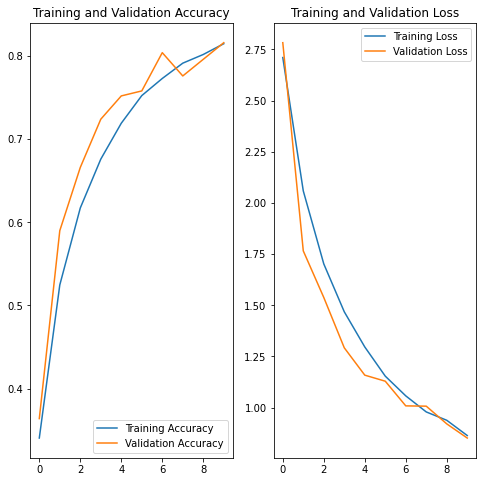

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['dense_22_accuracy']
val_acc = history.history['val_dense_22_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()